# ATP Webscrapping and Sentiment Analysis


## Purpose
The objective of the notebook os to scrape data from the web about top tennis players, then pull their related tweets from twitter in order to do a sentiment analysis (polarity) and compare them. WIP.

## Methodology
In order to do so, we will use the basic python librairies (pandas, numby, etc..) and myBeautifulSoup. We will scrape the data from wikipedia. The sentiment analysis will be done using NLP, NLTK and textblob. The first visualization will be done using matplotlib. The second visualization will be done using streamlit in order to have a full data applications (WIP). This notebook is for a personal use.

## Results
The analysis resulted in a plot of the rolling moving averages of the sentiment analysis of the top 5 players of the time (according to wikipedia).


## Suggested next steps
- debug why all players have very similar results
- adding other hashtag for the players regarding combinations of their first name, last name, nickname
- finding ways to pull tweets where only one player is mentionned
- adding multilingual treatment of the tweets with other NLP librairies (polyglot for example). For now we only pull english tweets, and use english NLP librairies.
- visualising using streamlit to beautify and make it easier to access (put all the code into one .py file to use streamlit


# Setup


In [1]:
# Data manipulation
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import os

#Webscrapping
import requests
from bs4 import BeautifulSoup

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

#twitter API
import tweepy as tw

#Streamlit for data app
import streamlit as st



# Data import
We retrieve all the required data for the analysis. At the end, we split the dataset in a train and test set to avoid data snooping;

# Retriving the data about each player

In [2]:
url = 'https://en.wikipedia.org/wiki/ATP_Rankings#Current_rankings'

#HEADERS to bypass captcha:

#headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'
#,'referer':'https://www.atptour.com/en/players/novak-djokovic/d643/overview'
#,'accept': '*/*'
#,'accept-encoding': 'gzip, deflate, br'
#,'accept-language': 'fr-FR,fr;q=0.9,en-US;q=0.8,en;q=0.7'
#,'cache-control': 'no-cache'
#,'cookie': '__cfduid=d1522a9664c920067a1a9d2f7aaa8d2d71610385495; _ga=GA1.2.318253811.1610385498; _gid=GA1.2.1504992291.1610385498; ASP.NET_SessionId=yf5rcx4ow3okfabm1rtktdct; __gads=ID=b4cff32c60288a14:T=1610458971:S=ALNI_MZpBOmYEFsihdpN37tHjFStEtwHqg; _fbp=fb.1.1610458973267.1340311442; __cf_bm=67f783195d315dfbe6d7100838e2b4c8196b995f-1610460675-1800-ATmr/omNbO8t+bXPuwj+pte7KrNcMcM22drQ90S9AshsE0tAD58IkGNb/EJRdlJI8FrtS/Kri8I4uOI7UdEAt+TxVo1T6LwukyZgWSA7PJuIYeaARRBHOLFJO7569AHgbTcVr2MtLz4BFyh70lzH3naENrTIF7sOFGoUj+CbJzMJ; _ce.s=v11.rlc~1610460677592; atpModalContainer=%2Fen%2Frankings%2Fsingles; _gat_UA-4616629-30=1'
#,'pragma': 'no-cache'
#,'referer': 'https://www.atptour.com/en/rankings/singles'
#,'sec-fetch-dest': 'script'
#,'sec-fetch-mode': 'no-cors'
#,'sec-fetch-site': 'same-origin'
#            ,'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
#        'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
#        'Accept-Encoding': 'none',
#        'Accept-Language': 'en-US,en;q=0.8',
#        'Connection': 'keep-alive'
#         }

result = requests.get(url=url
                     #, headers=headers
                     )
print(result.status_code)
#200 to 399 is good
#400 and more means error (acces or authentification)

200


In [3]:
soup = BeautifulSoup(result.content, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   ATP Rankings - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"YA7NSApAADsAAGicGZwAAAAO","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"ATP_Rankings","wgTitle":"ATP Rankings","wgCurRevisionId":1002000269,"wgRevisionId":1002000269,"wgArticleId":13480983,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles containing potentially dated statements from December 2020","All articles containing potentially dated statements","Articles containing potentially dated 

Here we access the correct table on wikipedia, that gives the ranking for men (I inspected the elements directly on the web page to find the right table and its beacons).

In [4]:
tables= soup.find_all('table',{"class":"wikitable nowrap"})
ATPsingleranks = tables[0]

Here we pull from that table the names, ranks and points for each player

In [5]:
ranks = []
points = []
players = []

#for table in ATPsingleranks:
rows = ATPsingleranks.find_all('tr')
    
for row in rows:
    cells = row.find_all('td')
        
    if len(cells) > 1:
        rank = cells[0]
        ranks.append(int(rank.text))
            
        player = cells[1]
        players.append(player.text.strip())
            
        point = cells[2]
        points.append((point.text.strip()))
            
            
df = pd.DataFrame(ranks, index= players, columns = ['Rank'])
df['ELO'] = points

df.head(10)

,Rank,ELO
Novak Djokovic (SRB),1,"12,030"
Rafael Nadal (ESP),2,"9,850"
Dominic Thiem (AUT),3,"9,125"
Daniil Medvedev (RUS),4,"8,470"
Roger Federer (SUI),5,"6,630"
Stefanos Tsitsipas (GRE),6,"5,925"
Alexander Zverev (GER),7,"5,525"
Andrey Rublev (RUS),8,"4,119"
Diego Schwartzman (ARG),9,"3,455"
Matteo Berrettini (ITA),10,"3,075"


Here we had hashtags associated to each player, in order to look for them in tweets

In [6]:
twitternames=[]
for name in players:
    twitternames.append('#'+name.split('\xa0')[0].split(' ')[1].lower())
df['twitternames'] = twitternames


Focus on the top5 players:

In [7]:
df= df.reset_index()
#df = df.head(10)
df = df.head(5)
df

,index,Rank,ELO,twitternames
0,Novak Djokovic (SRB),1,"12,030",#djokovic
1,Rafael Nadal (ESP),2,"9,850",#nadal
2,Dominic Thiem (AUT),3,"9,125",#thiem
3,Daniil Medvedev (RUS),4,"8,470",#medvedev
4,Roger Federer (SUI),5,"6,630",#federer


# Connecting to twitter API and retrieving tweets

Here we have our consumer tokens (developper account of twitter):

In [8]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

In [9]:
# Authenticate
auth = tw.OAuthHandler(consumer_key, consumer_secret)
# Set Tokens
auth.set_access_token(access_token, access_token_secret)
# Instantiate API
api = tw.API(auth, wait_on_rate_limit=True)

Here we pull X tweets for each of the players, and put them in lists:

In [10]:
tweets = []
timestamps = []
for i in df.index:
    hashtag = (df['twitternames'][i])
    name = (df['index'][i])
    query = tw.Cursor(api.search
                      ,result_type = "recent" #values can be: popular, mixed, recent
                      #,until= "YYYY-MM-DD" #the API can only find tweets for the last week anyway.                    
                      , q=hashtag, lang='en').items(100)
    #Note that unpopular players (not top3) do not have 100 tweets last week, which might be a problem.
    #I need to find a way to get more tweets for each player, while having tweets that only correspond to one player.
    for tweet in query:
        tweets.append(tweet.text)
        timestamps.append(tweet.created_at)

Then, we put all the data in a dataframe (so the tweets will be easier to process with NLP)

In [11]:
loop = pd.DataFrame({'Tweet': tweets,
     'Timestamp': timestamps
    })
loop

,Tweet,Timestamp
0,RT @SkySportsTennis: Novak #Djokovic and Rafae...,2021-01-25 18:19:47
1,"I would pay for ""#MiamiOpen"" tix for ourselves...",2021-01-25 18:03:07
2,Novak #Djokovic and Rafael #Nadal will start t...,2021-01-25 17:51:59
3,RT @jschroe36: It's week 🔥305🔥! Looking back o...,2021-01-25 14:26:14
4,RT @jschroe36: It's week 🔥305🔥! Looking back o...,2021-01-25 14:16:02
...,...,...
333,RT @kah22jad: My Favourite point of all time! ...,2021-01-25 09:38:41
334,RT @kah22jad: My Favourite point of all time! ...,2021-01-25 09:25:52
335,RT @kah22jad: My Favourite point of all time! ...,2021-01-25 09:25:51
336,RT @kah22jad: My Favourite point of all time! ...,2021-01-25 09:23:49


Here we create flags, that indicate to whom each tweet relates:

In [12]:
def identify_subject(tweet, refs):
    flag = 0 
    for ref in refs:
        if tweet.find(ref) != -1:
            flag = 1
    return flag

In [13]:
for i in df.index:
    hashtag = (df['twitternames'][i])
    name = (df['index'][i])
    loop[name]=loop['Tweet'].apply(lambda x: identify_subject(x, hashtag)) 

In [14]:
loop

,Tweet,Timestamp,Novak Djokovic (SRB),Rafael Nadal (ESP),Dominic Thiem (AUT),Daniil Medvedev (RUS),Roger Federer (SUI)
0,RT @SkySportsTennis: Novak #Djokovic and Rafae...,2021-01-25 18:19:47,1,1,1,1,1
1,"I would pay for ""#MiamiOpen"" tix for ourselves...",2021-01-25 18:03:07,1,1,1,1,1
2,Novak #Djokovic and Rafael #Nadal will start t...,2021-01-25 17:51:59,1,1,1,1,1
3,RT @jschroe36: It's week 🔥305🔥! Looking back o...,2021-01-25 14:26:14,1,1,1,1,1
4,RT @jschroe36: It's week 🔥305🔥! Looking back o...,2021-01-25 14:16:02,1,1,1,1,1
...,...,...,...,...,...,...,...
333,RT @kah22jad: My Favourite point of all time! ...,2021-01-25 09:38:41,1,1,1,1,1
334,RT @kah22jad: My Favourite point of all time! ...,2021-01-25 09:25:52,1,1,1,1,1
335,RT @kah22jad: My Favourite point of all time! ...,2021-01-25 09:25:51,1,1,1,1,1
336,RT @kah22jad: My Favourite point of all time! ...,2021-01-25 09:23:49,1,1,1,1,1


# Preprocessing with NLP

In [15]:
# Import stopwords
import nltk
from nltk.corpus import stopwords
# Import textblob
from textblob import Word, TextBlob

In [16]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
player_names = df['index'].values.tolist()
custom_stopwords = ['RT']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\louis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Here we clean the tweets, remove what is unnecessary:

In [17]:
def preprocess_tweets(tweet, custom_stopwords):
    processed_tweet = tweet
    processed_tweet.replace('[^\w\s]', '')
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in player_names)
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in stop_words)
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in custom_stopwords)
    processed_tweet = " ".join(Word(word).lemmatize() for word in processed_tweet.split())
    return(processed_tweet)

loop['Processed Tweet'] = loop['Tweet'].apply(lambda x: preprocess_tweets(x, custom_stopwords))
loop.head()

,Tweet,Timestamp,Novak Djokovic (SRB),Rafael Nadal (ESP),Dominic Thiem (AUT),Daniil Medvedev (RUS),Roger Federer (SUI),Processed Tweet
0,RT @SkySportsTennis: Novak #Djokovic and Rafae...,2021-01-25 18:19:47,1,1,1,1,1,@SkySportsTennis: Novak #Djokovic Rafael #Nada...
1,"I would pay for ""#MiamiOpen"" tix for ourselves...",2021-01-25 18:03:07,1,1,1,1,1,"I would pay ""#MiamiOpen"" tix (in sake birthday..."
2,Novak #Djokovic and Rafael #Nadal will start t...,2021-01-25 17:51:59,1,1,1,1,1,Novak #Djokovic Rafael #Nadal start 2021 seaso...
3,RT @jschroe36: It's week 🔥305🔥! Looking back o...,2021-01-25 14:26:14,1,1,1,1,1,@jschroe36: It's week 🔥305🔥! Looking back 2015...
4,RT @jschroe36: It's week 🔥305🔥! Looking back o...,2021-01-25 14:16:02,1,1,1,1,1,@jschroe36: It's week 🔥305🔥! Looking back 2015...


# Calculating sentiment with NLP


We will calculate polarity and subjectivity, however, only polarity interests us for the plots.

In [18]:
# Calculate polarity
loop['polarity'] = loop['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[0])
loop['subjectivity'] = loop['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[1])
loop.head()

,Tweet,Timestamp,Novak Djokovic (SRB),Rafael Nadal (ESP),Dominic Thiem (AUT),Daniil Medvedev (RUS),Roger Federer (SUI),Processed Tweet,polarity,subjectivity
0,RT @SkySportsTennis: Novak #Djokovic and Rafae...,2021-01-25 18:19:47,1,1,1,1,1,@SkySportsTennis: Novak #Djokovic Rafael #Nada...,0.0,0.0
1,"I would pay for ""#MiamiOpen"" tix for ourselves...",2021-01-25 18:03:07,1,1,1,1,1,"I would pay ""#MiamiOpen"" tix (in sake birthday...",0.0,0.0
2,Novak #Djokovic and Rafael #Nadal will start t...,2021-01-25 17:51:59,1,1,1,1,1,Novak #Djokovic Rafael #Nadal start 2021 seaso...,0.0,0.0
3,RT @jschroe36: It's week 🔥305🔥! Looking back o...,2021-01-25 14:26:14,1,1,1,1,1,@jschroe36: It's week 🔥305🔥! Looking back 2015...,0.0,0.5
4,RT @jschroe36: It's week 🔥305🔥! Looking back o...,2021-01-25 14:16:02,1,1,1,1,1,@jschroe36: It's week 🔥305🔥! Looking back 2015...,0.0,0.5


Here we have some stats about each player's sentiment:

In [19]:
for i in df.index:
    name = (df['index'][i])
    a = loop[loop[name]==1][[name, 'polarity', 'subjectivity']].groupby(name).agg([np.mean, 'count'])
    print(a)

2021-01-25 21:33:25.043 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


                      polarity       subjectivity      
                          mean count         mean count
Novak Djokovic (SRB)                                   
1                     0.123537   338      0.27997   338
                    polarity       subjectivity      
                        mean count         mean count
Rafael Nadal (ESP)                                   
1                   0.123537   338      0.27997   338
                     polarity       subjectivity      
                         mean count         mean count
Dominic Thiem (AUT)                                   
1                    0.123537   338      0.27997   338
                       polarity       subjectivity      
                           mean count         mean count
Daniil Medvedev (RUS)                                   
1                      0.123537   338      0.27997   338
                     polarity       subjectivity      
                         mean count         mean count
Ro

# Visualisation

Plotting the rolling moving averages for each player:

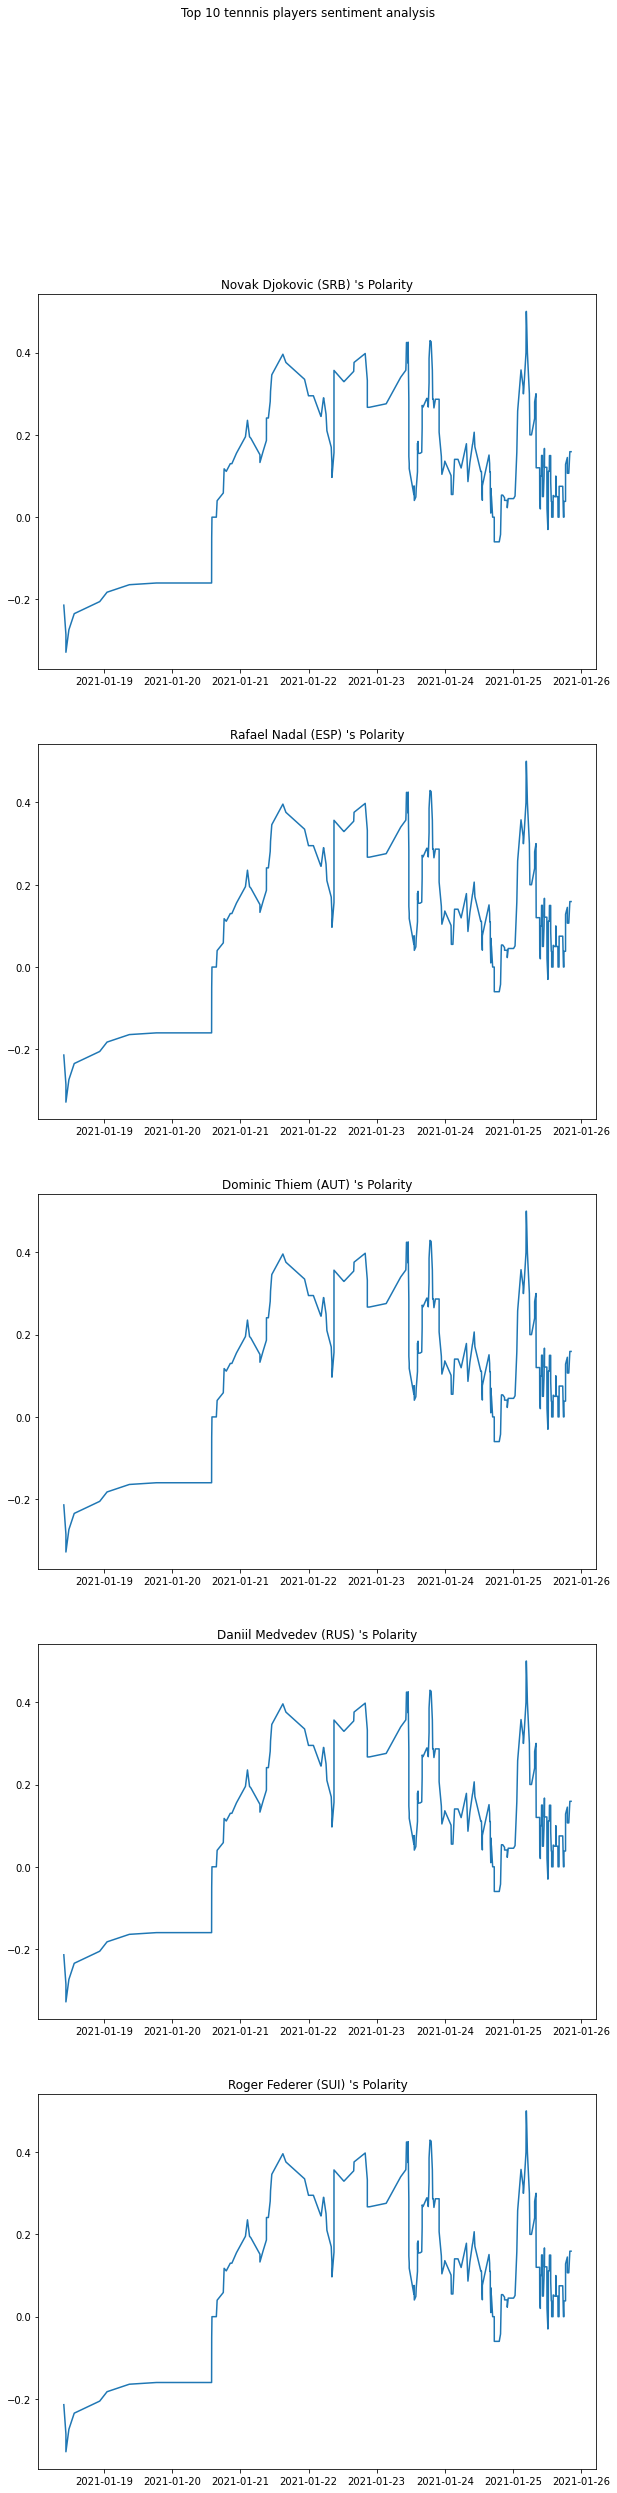

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 1, figsize=(10, 40))
c=0
for i in df.index:
    name = (df['index'][i])
    rolling = loop[loop[name]==1][['Timestamp', 'polarity']]
    rolling = rolling.sort_values(by='Timestamp', ascending=True)
    rolling['MA Polarity']=rolling.polarity.rolling(10, min_periods=3).mean()
    axes[c].plot(rolling['Timestamp'], rolling['MA Polarity'])
    axes[c].set_title("\n".join([name+" 's Polarity"]))
    c=c+1
fig.suptitle("\n".join(["Top 10 tennnis players sentiment analysis"]), y=0.98)

plt.show()

# References
We report here relevant references:
1. Nicholas Renotte
2. myBeautifulSoup tutorials
3. Aurélien Gejon
4. Andrew Ng